#Emotion Detection LSTM

**1. 프로젝트 주제**

- Emotion Detection LSTM

**2. 프로젝트 설명**

- 문장의 감정를 파악하는 모델을 구현하고자 하였습니다. 고객리뷰 등 에서 전체 리뷰를 읽지 않고 고객들이 느낀 감정들을 파악 하는데 사용할 수 있습니다.

**3. 데이터 설명**

- 여려 document에서 수집한 문장들과 감정이 저장되어 있는 dataset 을 사용했습니다.  


**4. 사용한 방법론**

- word2vec
- lstm

**5. 참고자료 및 레퍼런스** (최소 2개 ~ 최대 5개, 2개 까지만 '필수'로 생성되어 있습니다)

- https://buomsoo-kim.github.io/keras/2019/08/02/Easy-deep-learning-with-Keras-22.md/

- http://intelligence.korea.ac.kr/members/wschoi/nlp/deeplearning/Bidirectional-RNN-and-LSTM/

- https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [2]:
import numpy as np 
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

##Upload data

In [4]:
#upload file
from google.colab import files

files.upload()

Saving Emotions_database.zip to Emotions_database.zip


{'Emotions_database.zip': b'PK\x03\x04-\x00\x00\x00\x08\x00\xf95\x90PRn8\xfc\xff\xff\xff\xff\xff\xff\xff\xff\x08\x00\x14\x00test.txt\x01\x00\x10\x00\xa8\'\x03\x00\x00\x00\x00\x00\r#\x01\x00\x00\x00\x00\x00t}Y\x82\xeb:\x8e\xec\xff[\x85\xf7\xd1\xab\xa1-\xda\xe6M\r.\r\x99\xd7\xb5\xfa\x87\x88\x00H\xca\x99\xd5\x1f]\xe7\x9ec\xcb\x12Eb\x08\x04\x02e\xba\xdcs\x1e\xcb\xfc\xb8\xaci\x7f\xe6\xf5\xb2.\xfb\x9e\xe7\xcb\xb6\\\xec\xdf\xe6e\xbf|\xe7\xf5}I\xd3\xb5\xece9\xb6\xcbZ\x1e\xcf\xdd\xfe\xe1\xe7\xff\xb64\xccy\xdb\xfe\x9f}\xeex\ri\xc7E\xa6\xf7\xe5:.\x8f\xcb5\xdf\xd2\xb1\xe5K\xe1\xe5/\xdb\xb3\xec\xfb\xbb}\xe32g\xbb\xeceJ_\xf9\x82\x1f\xdd\xf2+\xd9\xef\xe7\xcb}]\xa6\xcb\x94\xbb\xef\x0f\xcb|\xd9/\xfc\xf8O\x9aw~|_t\xd9\xb1|\xe1#\xd3%m\xcf4\xe5\xe1\xf2S\xf6\'>\xd1\xfd\xd2\x98\xef\xbb\xfe\x1e\xf7\xb6\x1c\xff9\xf2~Y\xee\x97\xd5>\x9e\xe6\xe1\xf2\xce\xe3\xb8\xfc\\\xf6c,\xaf\xedr\xcc\x03\xee\xcb\x1exm+\xb3\x8dx\xe6\xf1}\x99\x965_\x96\xd7^\xa6\xb2\xed\xe5v\xd9\x9fi\xbe\xfc<m\xb9\x8a}a-\xdfy\xf8\xbf\x7f\x96\xb7\

In [5]:
!unzip Emotions_database.zip

Archive:  Emotions_database.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


In [6]:
# importing the dataset 
df_train = pd.read_csv('train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [7]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
print(df_train.shape, df_test.shape, df_val.shape)

(16000, 2) (2000, 2) (2000, 2)


### EDA

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'


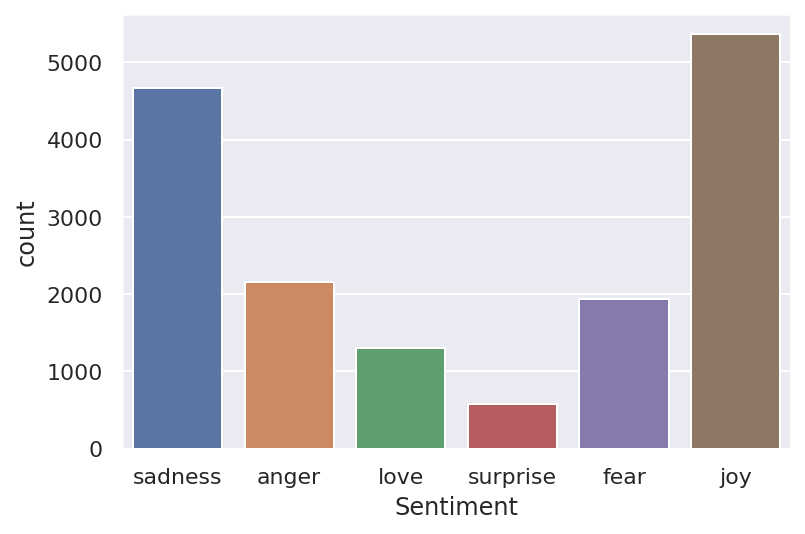

In [10]:
sns.countplot(df_train.Sentiment)
plt.show()

train data 에서 sadness, anger, love, surprise, fear, joy 감정이 분포되어 있습니다. 

Joy 와 sadness 가 가장 많게 나옵니다. 

문장 길이들을 확인해봅니다. 

In [11]:
df_train['Length'] = df_train.Input.apply(lambda x:len(x))

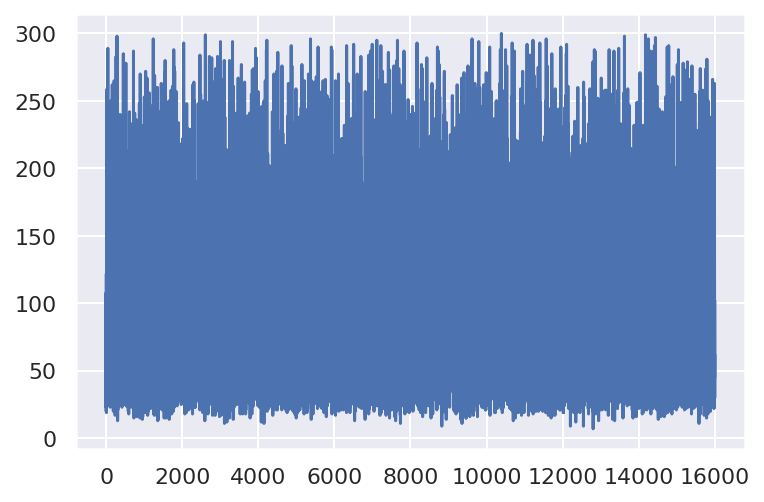

In [12]:
plt.plot(df_train.Length)
plt.show()

In [13]:
df_train.Length.max() # max length of our text body 

300

문장 길이들은 200에서 300 사이로 골고루 분포되어 있음을 확인합니다. 

### Text preprocessing 

In [14]:
# i'm using a text preprocessing library for this 
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall


  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-ej8hk88y
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-ej8hk88y
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11759 sha256=bcf22d6b1dd3c1236a0df83e5c281d16e69c2c535d86a8e149ba8ecef6e5f900
  Stored in directory: /tmp/pip-ephem-wheel-cache-ddclyedp/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [15]:
!pip install BeautifulSoup4


In [16]:
import preprocess_kgptalkie as ps


Text processing: 
- 모두 소문자로
- you're -> you are 로 
- email, html tag 제거
- base words 사용

In [17]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: ps.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: ps.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: ps.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: ps.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: ps.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: ps.make_base(x)) #ran -> run,
    return(df)

CPU times: user 2.14 ms, sys: 0 ns, total: 2.14 ms
Wall time: 6.59 ms


In [18]:
df_cleaned_train = text_preprocessing(df_train, 'Input')

In [19]:
df_cleaned_train.head()

,Input,Sentiment,Length
0,i do not feel humiliate,sadness,23
1,i can go from feel so hopeless to so damned ho...,sadness,108
2,i m grab a minute to post i feel greedy wrong,anger,48
3,i am ever feel nostalgic about the fireplace i...,love,92
4,i am feel grouchy,anger,20


test와 val data 에도 text clean 적용

In [20]:
df_cleaned_train['Sentiment']=df_cleaned_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Sentiment']=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_val['Sentiment']=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

##Encoding

#### Tokenizer Class를 이용하여 word vectors 로 변환


In [21]:
from keras.preprocessing.text import Tokenizer

In [22]:
num_words = 10000 # this means 15000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)


In [23]:
len(tokenizer.word_index) # this is whole unique words in our corpus
# but we are taking only 10000 words in our model

13951

In [24]:
from keras.preprocessing.sequence import pad_sequences

X_train=tokenizer.texts_to_sequences(df_cleaned_train['Input'])
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post')
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [25]:
from tensorflow.keras.utils import to_categorical


y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)


In [26]:
print(X_train_pad.shape, X_val_pad.shape)

(16000, 300) (2000, 300)


### gensim word2vec 사용하여 weight matrix 설정


In [27]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension

[==================================================] 100.0% 128.1/128.1MB downloaded


In [28]:
glove_gensim['cat'].shape[0]

100

Creating a word2Vec weight matrix 

In [29]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [30]:
gensim_weight_matrix.shape

(10000, 100)

##LSTM model (GPU 사용한 CuDNNLSTM 사용)

In [31]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
# tf.compat.v1.keras.layers.CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout



In [32]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [33]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [34]:
history_embedding = model.fit(X_train_pad,y_train, epochs = 25, batch_size = 120, validation_data=(X_val_pad, y_val),verbose = 1, callbacks= [es, mc]  )


Epoch 1/25
134/134 [==============================] - 36s 192ms/step - loss: 1.4156 - accuracy: 0.4568 - val_loss: 1.1353 - val_accuracy: 0.5845

Epoch 00001: val_accuracy improved from -inf to 0.58450, saving model to ./model.h5
Epoch 2/25
134/134 [==============================] - 25s 184ms/step - loss: 1.0655 - accuracy: 0.6088 - val_loss: 0.7648 - val_accuracy: 0.7235

Epoch 00002: val_accuracy improved from 0.58450 to 0.72350, saving model to ./model.h5
Epoch 3/25
134/134 [==============================] - 25s 185ms/step - loss: 0.8067 - accuracy: 0.7014 - val_loss: 0.5965 - val_accuracy: 0.7910

Epoch 00003: val_accuracy improved from 0.72350 to 0.79100, saving model to ./model.h5
Epoch 4/25
134/134 [==============================] - 25s 184ms/step - loss: 0.6610 - accuracy: 0.7540 - val_loss: 0.4656 - val_accuracy: 0.8335

Epoch 00004: val_accuracy improved from 0.79100 to 0.83350, saving model to ./model.h5
Epoch 5/25
134/134 [==============================] - 25s 187ms/step - 

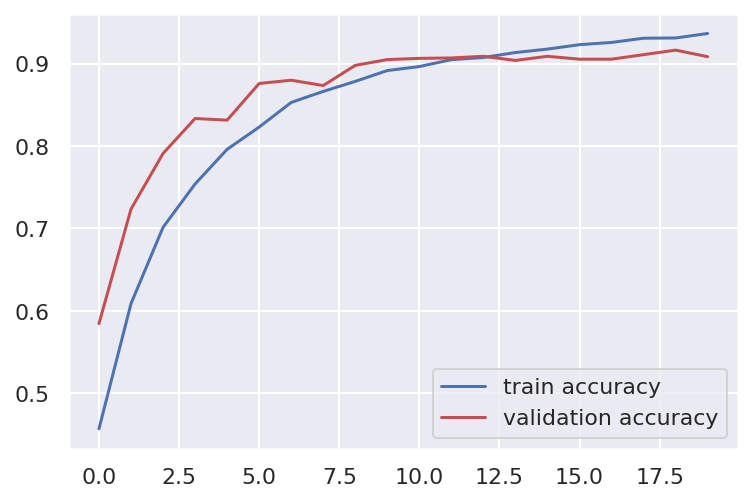

In [35]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

train accuracy 와 val accuracy 는 90%대로 비슷하게 나옴

#### test data

In [49]:
model.evaluate(X_test_pad, y_test) 

63/63 [==============================] - 2s 36ms/step - loss: 0.2250 - accuracy: 0.9090


[0.22503632307052612, 0.9089999794960022]

In [37]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)

In [38]:
y_true = np.argmax(y_test, axis = 1)


In [39]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       694
           1       0.97      0.87      0.92       308
           2       0.79      0.81      0.80       155
           3       0.92      0.97      0.94       556
           4       0.82      0.92      0.86       200
           5       0.83      0.63      0.72        87

    accuracy                           0.91      2000
   macro avg       0.88      0.85      0.86      2000
weighted avg       0.91      0.91      0.91      2000



accuracy 는 91%로 우수하게 나옴

# 새로운 문장들 활용해보기

In [40]:
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key

In [41]:
def predict(sentence):
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=300,padding='post')
    ans=get_key(model.predict_classes(sentence_padded))
    print("The emotion predicted is",ans)

In [46]:
predict(str(input('Enter a sentence : ')))


Enter a sentence : awesome product
The emotion predicted is joy


##requirement.txt 저장

In [48]:
pip freeze > requirements.txt